In [1]:
import numpy as np
import phase_reconstruct as pr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pyedflib
import biosppy

using mkl_fft


In [2]:
def read_rri(rri_file):
    f = open(rri_file, 'r')
    f.readline()
    f.readline()
    """
    Get start time of this rri file
    """
    rr_startdate = f.readline()
    index_start = rr_startdate.find("=") + 1
    rr_startdate = rr_startdate[index_start:-1]
    rr_starttime = f.readline()
    index_start = rr_starttime.find("=") + 1
    rr_starttime = rr_starttime[index_start:-1]
    file_starttime = rr_startdate + " " + rr_starttime

    try:
        file_starttime = datetime.datetime.strptime(file_starttime,
                                                    "%d.%m.%Y %H:%M:%S")
    except ValueError:
        file_starttime = datetime.datetime.strptime(file_starttime,
                                                    "%Y-%m-%d %H:%M:%S")
    """
    get frequency of rri
    """
    line = f.readline()
    index_start = line.find("=") + 1
    freq = int(line[index_start:])

    f.close()
    df = pd.read_csv(rri_file,
                     skiprows=6,
                     sep="\t",
                    names=["rposition", 'type'])

#     df = df[df.type == "N"]
    return file_starttime, df.rposition.values

In [3]:
start_time, rposition = read_rri("D:/Aktigraphie/Analyse_Somno_TUM/RRI/SL161_SL161_(1)Somno.rri")
rposition = rposition

edffile = pyedflib.EdfReader("D:/Aktigraphie/SOMNOwatch plus/EDF/SL161_SL161_(1).edf")
edf_starttime = edffile.getStartdatetime()
events = edffile.readAnnotations()
events = (events[0] * 256).astype(int)
t_delta = (start_time - edf_starttime).seconds
rposition = rposition - t_delta * 256
ecg = edffile.readSignal(0)[events[0]: events[1]]
rposition = rposition[(rposition < events[1]) & (rposition > events[0])] - events[0]
ecg = ecg[:rposition[-1] + 2]
ecg = ecg - np.mean(ecg)
ecg = ecg / np.std(ecg)
edffile.close()


rri = np.diff(rposition)
T0 = (rposition[-1] - rposition[0]) / (rposition.size - 5) / 256
w0 = np.pi * 2 / T0
T0

0.9300684058021307

(3590.0, 3640.0)

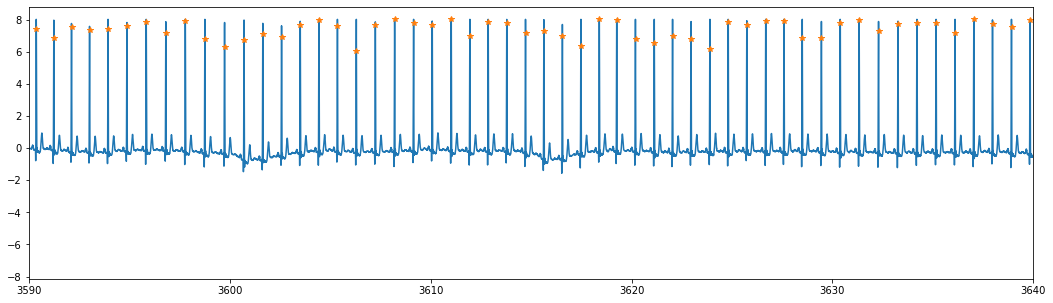

In [5]:
start = 3590
end = 3640
t = np.linspace(0, ecg.size / 256, ecg.size)
plt.figure(figsize=(18, 5))
plt.plot(t, ecg)
plt.plot(rposition / 256, ecg[rposition], "*")
plt.xlim([start, end])

In [6]:
rposition = biosppy.signals.ecg.correct_rpeaks(ecg, rposition, sampling_rate=256)[0]

(61440.0, 76800.0)

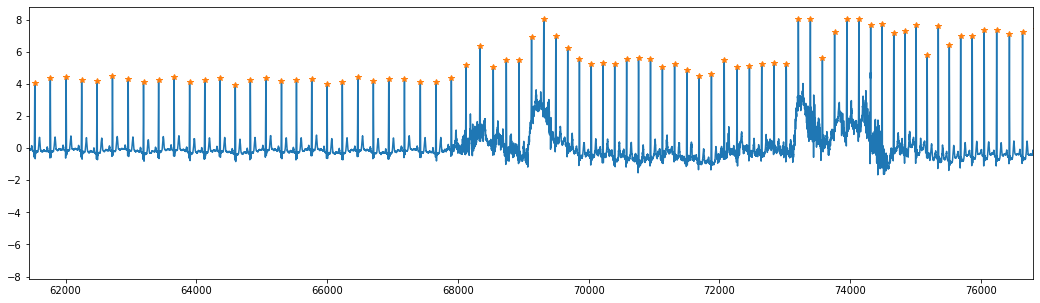

In [7]:
start = 60 * 4
end = 60 * 5
plt.figure(figsize=(18, 5))
plt.plot(ecg)
plt.plot(rposition, ecg[rposition], "*")
plt.xlim([256 * start, 256 * end])

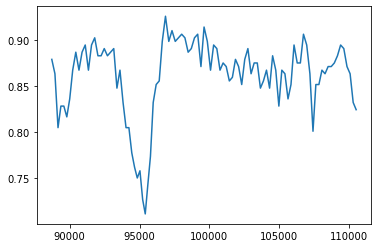

In [8]:
plt.plot(rposition[400:500], rri[400:500] / 256)

In [77]:
T0

0.9360338028134157

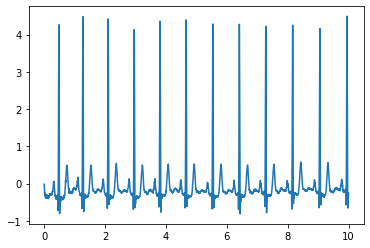

In [59]:
plt.figure()
plt.plot(t[:256 * 10], ecg[:256 * 10])

In [138]:
protophase = pr.tools.get_protophase(ecg, rposition)
phase = pr.get_phase.proto_to_phase_fast(protophase, 48, method="fft").real
phase_fast = pr.get_phase.proto_to_phase_fast(protophase, 2000)

phase, _ = pr.tools.flatten_phase(phase)
phase_fast, _ = pr.tools.flatten_phase(phase_fast)

0.9299454317748092


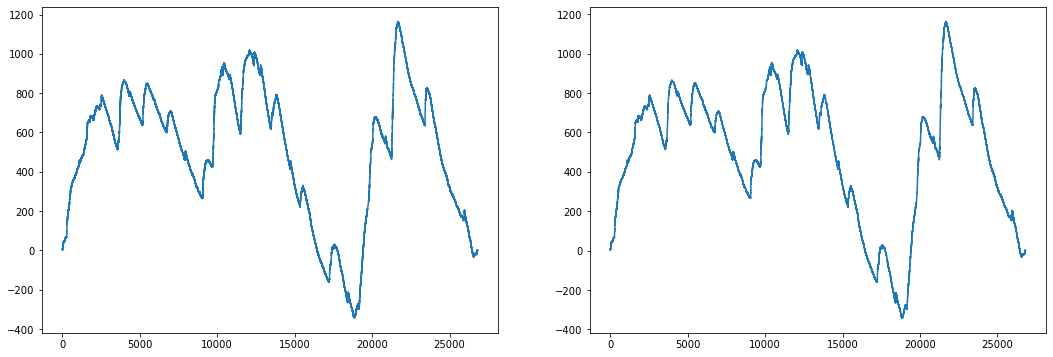

In [87]:
T0 = (rposition[-1] - rposition[0]) / (rposition.size - 1) / 256
w0 = np.pi * 2 / T0
print(T0)

start = 0
end = -1
t_duration = t[rposition[start]: rposition[end]]
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t_duration, (protophase[rposition[start]: rposition[end]] - w0 * t_duration))
# plt.ylim([9.5, 13])
plt.subplot(122)
plt.plot(t_duration, phase[rposition[start]: rposition[end]] - w0 * t_duration)
# plt.plot(t_duration, phase_fast[rposition[start]: rposition[end]] - w0 * t_duration)
# plt.ylim([633, 636.5])

0.93046875


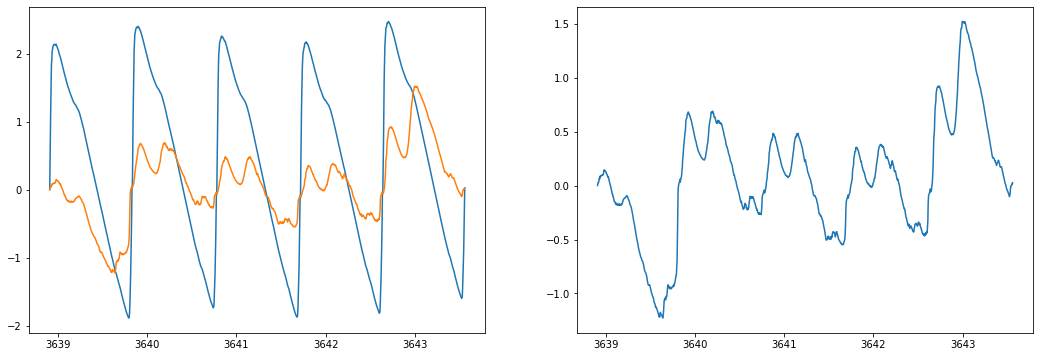

In [145]:
start = 4000
end = 4005

T0 = (rposition[start] - rposition[end]) / (start - end) / 256
w0 = np.pi * 2 / T0
print(T0)

t_duration = t[rposition[start]: rposition[end]]
protophase_plot = protophase[rposition[start]: rposition[end]]
protophase_plot = protophase_plot - protophase_plot[0] - w0 * (t_duration - t_duration[0])
phase_plot = phase[rposition[start]:rposition[end]]
phase_plot = phase_plot - phase_plot[0] - w0 * (t_duration - t_duration[0])

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t_duration, protophase_plot)
plt.plot(t_duration, phase_plot)

# plt.ylim([-1.5, 2.5])
plt.subplot(122)
plt.plot(t_duration, phase_plot)
# plt.plot(t_duration, phase_fast[rposition[start]: rposition[end]] - w0 * t_duration)
# plt.ylim([-1.5, 2.5])

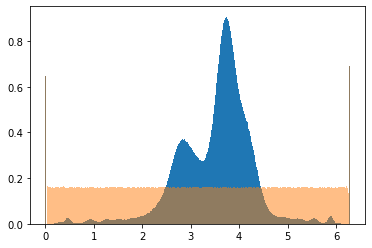

In [120]:
plt.hist(protophase % (2 * np.pi), bins=1000, density=True, )
# plt.hist(phase.real, bins=100)
plt.hist(phase % (2 * np.pi),bins=1000, density=True, alpha=0.5)
plt.show()

In [39]:
%timeit pr.get_phase.proto_to_phase_fast(protophase, 200)

582 ms ± 7.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
ecg_signal = ecg[: rposition[40] + 256]
ecg_sa = pr.tools.hilbert(ecg_signal)

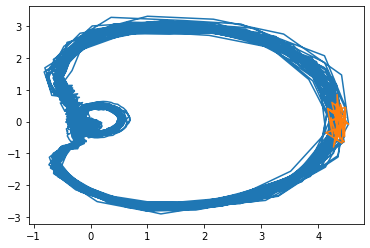

In [130]:
plt.plot(ecg_sa.real, ecg_sa.imag)
plt.plot(ecg_sa.real[rposition[0:40]], ecg_sa.imag[rposition[0:40]])